# Training PhoBERT cho Phát Hiện Nội Dung Độc Hại Tiếng Việt

Notebook này training PhoBERT model để phát hiện:
- **safe**: Nội dung an toàn
- **toxic**: Nội dung độc hại, chửi rủa
- **hate**: Kỳ thị, phân biệt vùng miền/giới tính/tôn giáo
- **violence**: Bạo lực, đe dọa
- **nsfw**: Nội dung 18+
- **suicide**: Tự tử, tự sát

## 1. Cài Đặt Tất Cả Thư Viện

# Cài đặt tất cả thư viện cần thiết
!pip install transformers datasets torch pandas numpy scikit-learn tqdm seaborn matplotlib -q

print("✓ Đã cài đặt xong tất cả thư viện!")

## 2. Import Thư Viện

In [2]:
# Import tất cả thư viện
import torch
import pandas as pd
import numpy as np
import os
import glob
import json
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

print("✓ Import thành công!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

✓ Import thành công!
PyTorch version: 2.9.0+cu126
CUDA available: True
Device: cuda


## 3. Download Dataset Tiếng Việt

In [3]:
"""
Download Dataset Tiếng Việt từ GitHub
QUAN TRỌNG: Chạy cell này TRƯỚC KHI load dataset!
"""

import os
import glob

print("="*60)
print("ĐANG DOWNLOAD DATASET TIẾNG VIỆT")
print("="*60)

# 1. ViHSD - Vietnamese Hate Speech Detection (Khuyên dùng nhất)
print("\nĐang download ViHSD dataset...")
print("   Nguồn: https://github.com/sonlam1102/vihsd")

!git clone https://github.com/sonlam1102/vihsd.git

if os.path.exists('vihsd'):
    print("   Đã download ViHSD thành công!")
else:
    print("   Lỗi download ViHSD")

# 2. UIT-ViCTSD Dataset
print("\nĐang download UIT-ViCTSD dataset...")
print("   Nguồn: https://github.com/uitnlp/vietnamese-toxic-comment")

!git clone https://github.com/uitnlp/vietnamese-toxic-comment.git

if os.path.exists('vietnamese-toxic-comment'):
    print("   Đã download UIT-ViCTSD thành công!")
else:
    print("   Lỗi download UIT-ViCTSD")

# Kiểm tra files đã download
print("\n" + "="*60)
print("KIỂM TRA FILES ĐÃ DOWNLOAD")
print("="*60)

if os.path.exists('vihsd'):
    print("\nViHSD folder:")
    csv_files = glob.glob('vihsd/**/*.csv', recursive=True)
    if csv_files:
        print(f"   Tìm thấy {len(csv_files)} file(s) CSV:")
        for f in csv_files[:5]:  # Show first 5
            print(f"   - {f}")
    else:
        print("   Không tìm thấy file CSV")
        print("   Files trong thư mục:")
        !ls -la vihsd/ 2>/dev/null || dir vihsd\ 2>NUL

if os.path.exists('vietnamese-toxic-comment'):
    print("\nUIT-ViCTSD folder:")
    csv_files = glob.glob('vietnamese-toxic-comment/**/*.csv', recursive=True)
    if csv_files:
        print(f"   Tìm thấy {len(csv_files)} file(s) CSV:")
        for f in csv_files[:5]:
            print(f"   - {f}")
    else:
        print("   Không tìm thấy file CSV")
        print("   Files trong thư mục:")
        !ls -la vietnamese-toxic-comment/ 2>/dev/null || dir vietnamese-toxic-comment\ 2>NUL

print("\n" + "="*60)
print("HOÀN TẤT DOWNLOAD!")
print("="*60)
print("\nBây giờ chạy cell tiếp theo để load dataset")

ĐANG DOWNLOAD DATASET TIẾNG VIỆT

Đang download ViHSD dataset...
   Nguồn: https://github.com/sonlam1102/vihsd
Cloning into 'vihsd'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 63 (delta 24), reused 15 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 1.87 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (24/24), done.
   Đã download ViHSD thành công!

Đang download UIT-ViCTSD dataset...
   Nguồn: https://github.com/uitnlp/vietnamese-toxic-comment
Cloning into 'vietnamese-toxic-comment'...
fatal: could not read Username for 'https://github.com': No such device or address
   Lỗi download UIT-ViCTSD

KIỂM TRA FILES ĐÃ DOWNLOAD

ViHSD folder:
   Không tìm thấy file CSV
   Files trong thư mục:
total 848
drwxr-xr-x 5 root root   4096 Dec  7 15:17 .
drwxr-xr-x 1 root root   4096 Dec  7 15:17 ..
drwxr-xr-x 2 root root   4096 Dec  7 15:17 data
drwxr-xr-x 8 root root   4096 

In [4]:
# Kiểm tra cấu trúc thư mục sau khi clone
import os
import glob

print("="*60)
print("KIỂM TRA CẤU TRÚC THỦ MỤC")
print("="*60)

# Kiểm tra ViHSD
if os.path.exists('vihsd'):
    print("\nFolder 'vihsd' tồn tại!")
    print("\nCấu trúc thư mục:")
    for root, dirs, files in os.walk('vihsd'):
        level = root.replace('vihsd', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:10]:  # Show first 10 files
            print(f'{subindent}{file}')
        if len(files) > 10:
            print(f'{subindent}... và {len(files)-10} files khác')

    print("\nTất cả files CSV:")
    csv_files = glob.glob('vihsd/**/*', recursive=True)
    csv_files = [f for f in csv_files if os.path.isfile(f)]
    for f in csv_files[:20]:
        print(f"  - {f}")
else:
    print("\nFolder 'vihsd' KHÔNG tồn tại!")

# Kiểm tra vietnamese-toxic-comment
print("\n" + "="*60)
if os.path.exists('vietnamese-toxic-comment'):
    print("\nFolder 'vietnamese-toxic-comment' tồn tại!")
    print("\nCấu trúc thư mục:")
    for root, dirs, files in os.walk('vietnamese-toxic-comment'):
        level = root.replace('vietnamese-toxic-comment', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:10]:
            print(f'{subindent}{file}')
        if len(files) > 10:
            print(f'{subindent}... và {len(files)-10} files khác')

    print("\nTất cả files:")
    all_files = glob.glob('vietnamese-toxic-comment/**/*', recursive=True)
    all_files = [f for f in all_files if os.path.isfile(f)]
    for f in all_files[:20]:
        print(f"  - {f}")
else:
    print("\nFolder 'vietnamese-toxic-comment' KHÔNG tồn tại!")

print("\n" + "="*60)

KIỂM TRA CẤU TRÚC THỦ MỤC

Folder 'vihsd' tồn tại!

Cấu trúc thư mục:
vihsd/
  ViHSD_DNN.ipynb
  ViHSD_monolingual_Transformers.ipynb
  ViHSD_multilingual_Transformers.ipynb
  README.md
  tokenizer/
    tokenizer.pickle
    tokenizer_aug.pickle
  .git/
    description
    config
    packed-refs
    index
    HEAD
    objects/
      info/
      pack/
        pack-15fd9a26e38504692c93cc9344818a7ccc95806d.pack
        pack-15fd9a26e38504692c93cc9344818a7ccc95806d.idx
    refs/
      remotes/
        origin/
          HEAD
      heads/
        main
      tags/
    info/
      exclude
    branches/
    logs/
      HEAD
      refs/
        remotes/
          origin/
            HEAD
        heads/
          main
    hooks/
      pre-rebase.sample
      pre-push.sample
      push-to-checkout.sample
      prepare-commit-msg.sample
      post-update.sample
      commit-msg.sample
      update.sample
      fsmonitor-watchman.sample
      applypatch-msg.sample
      pre-receive.sample
      ... v

In [5]:
"""
Bước 2
Giải nén dataset và fix lỗi
"""

import zipfile
import os

print("="*60)
print("GIẢI NÉN DATASET")
print("="*60)

# 1. Giải nén ViHSD
vihsd_zip = 'vihsd/data/vihsd.zip'
if os.path.exists(vihsd_zip):
    print("\nĐang giải nén ViHSD dataset...")
    try:
        with zipfile.ZipFile(vihsd_zip, 'r') as zip_ref:
            zip_ref.extractall('vihsd/data/')
        print("   Đã giải nén thành công!")

        # Liệt kê files sau khi giải nén
        print("\nFiles trong vihsd/data/ sau khi giải nén:")
        for file in os.listdir('vihsd/data/'):
            print(f"   - {file}")
    except Exception as e:
        print(f"   Lỗi: {e}")
else:
    print("Không tìm thấy vihsd.zip")

# 2. Thử download lại UIT-ViCTSD nếu chưa có
if not os.path.exists('vietnamese-toxic-comment'):
    print("\nThử download lại UIT-ViCTSD...")
    try:
        !git clone https://github.com/uitnlp/vietnamese-toxic-comment.git
        if os.path.exists('vietnamese-toxic-comment'):
            print("   Download thành công!")
        else:
            print("   Vẫn không download được")
    except:
        print("  Lỗi download")

print("\n" + "="*60)
print("HOÀN TẤT!")
print("="*60)

GIẢI NÉN DATASET

Đang giải nén ViHSD dataset...
   Đã giải nén thành công!

Files trong vihsd/data/ sau khi giải nén:
   - .gitkeep
   - vihsd
   - __MACOSX
   - vihsd.zip

Thử download lại UIT-ViCTSD...
Cloning into 'vietnamese-toxic-comment'...
fatal: could not read Username for 'https://github.com': No such device or address
   Vẫn không download được

HOÀN TẤT!


## 4. Giải Nén Dataset

## 5. Load và Chuẩn Bị Dataset

In [6]:
"""
Load và xử lý dataset tiếng Việt
Chuẩn hóa labels phù hợp cho app Instagram

QUAN TRỌNG: Chỉ chạy cell này SAU KHI đã download dataset!
"""

import pandas as pd
import os
import glob

class VietnameseDatasetLoader:
    """Class để load và xử lý dataset tiếng Việt"""

    def __init__(self):
        self.all_data = []
        self.label_mapping = {
            # Mapping từ labels gốc sang labels chuẩn
            'CLEAN': 'safe',
            'OFFENSIVE': 'toxic',
            'HATE': 'hate',
            'toxic': 'toxic',
            'safe': 'safe',
            'hate': 'hate',
            'violence': 'violence',
            'nsfw': 'nsfw',
            'suicide': 'suicide',
            '0': 'safe',
            '1': 'toxic',
            '2': 'hate'
        }

    def load_vihsd(self, base_path='./vihsd'):
        """
        Load ViHSD dataset
        Format: free_text, label_id (0=CLEAN, 1=OFFENSIVE, 2=HATE)
        """
        print("Đang load ViHSD dataset...")

        try:
            # Tìm tất cả file CSV trong thư mục data/vihsd/
            csv_files = []

            # Thử tìm trong vihsd/data/vihsd/
            vihsd_data_path = os.path.join(base_path, 'data', 'vihsd')
            if os.path.exists(vihsd_data_path):
                csv_files = glob.glob(f'{vihsd_data_path}/*.csv', recursive=False)

            # Nếu không có, thử tìm trong vihsd/data/
            if not csv_files:
                csv_files = glob.glob(f'{base_path}/data/*.csv', recursive=False)

            # Nếu vẫn không có, tìm toàn bộ
            if not csv_files:
                csv_files = glob.glob(f'{base_path}/**/*.csv', recursive=True)

            if not csv_files:
                print(f"  Không tìm thấy file CSV trong {base_path}")
                return pd.DataFrame()

            dfs = []
            for file in csv_files:
                print(f"  Đang đọc: {os.path.basename(file)}")
                try:
                    # Đọc CSV
                    df = pd.read_csv(file, encoding='utf-8')

                    # Chuẩn hóa tên columns
                    df.columns = df.columns.str.lower().str.strip()

                    print(f"    Columns: {list(df.columns)}")

                    # Tìm text column (ưu tiên free_text)
                    text_col = None
                    for col in ['free_text', 'comment', 'text', 'content', 'sentence']:
                        if col in df.columns:
                            text_col = col
                            break

                    # Tìm label column (ưu tiên label_id)
                    label_col = None
                    for col in ['label_id', 'label', 'sentiment', 'category', 'class']:
                        if col in df.columns:
                            label_col = col
                            break

                    if text_col and label_col:
                        df = df[[text_col, label_col]].rename(columns={
                            text_col: 'text',
                            label_col: 'label'
                        })

                        # Chuyển label sang string và map
                        df['label'] = df['label'].astype(str).str.strip()
                        df['label'] = df['label'].map(self.label_mapping).fillna('safe')
                        df['source'] = 'vihsd'

                        # Loại bỏ NaN
                        df = df.dropna(subset=['text', 'label'])

                        dfs.append(df)
                        print(f"    Loaded {len(df)} samples")
                    else:
                        print(f"    Thiếu text hoặc label column")

                except Exception as e:
                    print(f"    Lỗi: {str(e)[:100]}")

            if dfs:
                result = pd.concat(dfs, ignore_index=True)
                print(f"  Tổng: {len(result)} samples từ ViHSD")
                return result
            else:
                print("  Không load được data từ ViHSD")
                return pd.DataFrame()

        except Exception as e:
            print(f"  Lỗi: {e}")
            return pd.DataFrame()

    def load_uit_victsd(self, base_path='./vietnamese-toxic-comment'):
        """Load UIT-ViCTSD dataset"""
        print("\nĐang load UIT-ViCTSD dataset...")

        if not os.path.exists(base_path):
            print(f"  Folder không tồn tại, bỏ qua")
            return pd.DataFrame()

        try:
            csv_files = glob.glob(f'{base_path}/**/*.csv', recursive=True)

            if not csv_files:
                print(f"  Không tìm thấy file CSV")
                return pd.DataFrame()

            dfs = []
            for file in csv_files:
                print(f"  Đang đọc: {os.path.basename(file)}")
                try:
                    df = pd.read_csv(file, encoding='utf-8')
                    df.columns = df.columns.str.lower().str.strip()

                    text_col = None
                    for col in ['free_text', 'comment', 'text', 'content', 'sentence']:
                        if col in df.columns:
                            text_col = col
                            break

                    label_col = None
                    for col in ['label_id', 'label', 'sentiment', 'category']:
                        if col in df.columns:
                            label_col = col
                            break

                    if text_col and label_col:
                        df = df[[text_col, label_col]].rename(columns={
                            text_col: 'text',
                            label_col: 'label'
                        })

                        df['label'] = df['label'].astype(str).str.strip()
                        df['label'] = df['label'].map(self.label_mapping).fillna('safe')
                        df['source'] = 'uit_victsd'
                        df = df.dropna(subset=['text', 'label'])
                        dfs.append(df)
                        print(f"    Loaded {len(df)} samples")

                except Exception as e:
                    print(f"    Lỗi: {str(e)[:100]}")

            if dfs:
                result = pd.concat(dfs, ignore_index=True)
                print(f"  Tổng: {len(result)} samples từ UIT-ViCTSD")
                return result
            else:
                return pd.DataFrame()

        except Exception as e:
            print(f"  Lỗi: {e}")
            return pd.DataFrame()

    def load_all_vietnamese_datasets(self):
        """Load tất cả dataset tiếng Việt"""
        print("=" * 60)
        print("ĐANG LOAD TẤT CẢ DATASET TIẾNG VIỆT")
        print("=" * 60)

        dfs = []

        # Load ViHSD
        if os.path.exists('vihsd'):
            vihsd_df = self.load_vihsd()
            if not vihsd_df.empty:
                dfs.append(vihsd_df)
        else:
            print("Folder 'vihsd' không tồn tại")

        # Load UIT-ViCTSD (optional)
        if os.path.exists('vietnamese-toxic-comment'):
            victsd_df = self.load_uit_victsd()
            if not victsd_df.empty:
                dfs.append(victsd_df)
        else:
            print("\nFolder 'vietnamese-toxic-comment' không tồn tại (optional)")

        if dfs:
            # Merge tất cả
            combined = pd.concat(dfs, ignore_index=True)

            # Clean data
            combined = combined.dropna(subset=['text', 'label'])
            combined = combined[combined['text'].str.strip() != '']
            combined = combined.drop_duplicates(subset=['text'])

            print("\n" + "=" * 60)
            print("THỐNG KÊ DATASET TỔNG HỢP")
            print("=" * 60)
            print(f"Tổng số samples: {len(combined)}")
            print(f"\nPhân bố theo label:")
            print(combined['label'].value_counts())
            print(f"\nPhân bố theo nguồn:")
            print(combined['source'].value_counts())
            print("=" * 60)

            self.all_data = combined
            return combined
        else:
            print("\nKHÔNG LOAD ĐƯỢC DATASET NÀO!")
            print("\nTroubleshooting:")
            print("1. Kiểm tra đã chạy cell download + giải nén chưa?")
            print("2. Kiểm tra folder 'vihsd/data/vihsd/' có file CSV không?")
            print("3. Chạy lại cell giải nén")
            return pd.DataFrame()

    def save_dataset(self, output_path='vietnamese_dataset.csv'):
        """Lưu dataset đã xử lý"""
        if len(self.all_data) > 0:
            self.all_data.to_csv(output_path, index=False, encoding='utf-8-sig')
            print(f"\nĐã lưu {len(self.all_data)} samples vào {output_path}")
        else:
            print("\nKhông có data để lưu!")

# Tạo loader và load dataset
print("Bắt đầu load dataset...\n")
vietnamese_loader = VietnameseDatasetLoader()
vietnamese_dataset = vietnamese_loader.load_all_vietnamese_datasets()

# Lưu dataset nếu load thành công
if not vietnamese_dataset.empty:
    vietnamese_loader.save_dataset('vietnamese_instagram_dataset.csv')

    # Hiển thị sample
    print("\nSample data (5 mẫu ngẫu nhiên):")
    print(vietnamese_dataset.sample(min(5, len(vietnamese_dataset)))[['text', 'label', 'source']])

    print("\nDataset đã sẵn sàng để train model!")
else:
    print("\nKhông có dataset để tiếp tục")
    print("Hãy kiểm tra lại các bước trên!")

Bắt đầu load dataset...

ĐANG LOAD TẤT CẢ DATASET TIẾNG VIỆT
Đang load ViHSD dataset...
  Đang đọc: test.csv
    Columns: ['free_text', 'label_id']
    Loaded 6680 samples
  Đang đọc: train.csv
    Columns: ['free_text', 'label_id']
    Loaded 24046 samples
  Đang đọc: dev.csv
    Columns: ['free_text', 'label_id']
    Loaded 2672 samples
  Tổng: 33398 samples từ ViHSD

Folder 'vietnamese-toxic-comment' không tồn tại (optional)

THỐNG KÊ DATASET TỔNG HỢP
Tổng số samples: 30602

Phân bố theo label:
label
safe     25173
hate      3334
toxic     2095
Name: count, dtype: int64

Phân bố theo nguồn:
source
vihsd    30602
Name: count, dtype: int64

Đã lưu 30602 samples vào vietnamese_instagram_dataset.csv

Sample data (5 mẫu ngẫu nhiên):
                                                    text label source
14971         Thử ko cho giải xem . Chống phá nhà nước à  safe  vihsd
19740                     Sói hai kiểu gượng gạo ép buộc  safe  vihsd
32074                                         Đây

### 5.1. Cân Bằng Dataset và Chia Tập Train/Val/Test

In [7]:
"""
Class để cân bằng dataset và chia tập Train/Val/Test
"""

class VietnameseDatasetPreparer:
    """Chuẩn bị dataset tiếng Việt: thêm data, cân bằng, chia tập"""

    def __init__(self, dataset_df):
        self.dataset = dataset_df.copy()
        print(f"✓ Khởi tạo với {len(self.dataset)} samples")

    def add_sensitive_samples(self):
        """
        Bổ sung các mẫu nhạy cảm tiếng Việt cho các nhãn hiếm
        Tập trung vào: suicide, nsfw, violence
        """
        print("\nBổ sung dữ liệu nhạy cảm tiếng Việt...")

        sensitive_samples = [
            # === SAFE SAMPLES ===
            ("Hôm nay trời đẹp quá!", "safe"),
            ("Ảnh đẹp lắm bạn ơi!", "safe"),
            ("Cảm ơn bạn nhiều nhé", "safe"),
            ("Chúc bạn một ngày tốt lành", "safe"),
            ("View này đẹp ghê!", "safe"),
            ("Món này ngon quá!", "safe"),
            ("Outfit hôm nay xinh ghê", "safe"),
            ("Bài hát hay quá đi!", "safe"),

            # === TOXIC SAMPLES ===
            ("Mày ngu vãi lồn", "toxic"),
            ("Đồ con chó, đm mày", "toxic"),
            ("Cút đi thằng ngu", "toxic"),
            ("Địt mẹ mày ngu vcl", "toxic"),
            ("Vãi cả lồn, ngu vãi", "toxic"),
            ("Đồ ngu như súc vật", "toxic"),
            ("Mày là thằng chó đẻ", "toxic"),
            ("Đcm thằng này ngu thật", "toxic"),

            # === HATE SPEECH SAMPLES ===
            ("Bọn đồng tính phải chết hết đi", "hate"),
            ("Người da đen thật đáng ghét", "hate"),
            ("Phụ nữ chỉ biết ở nhà", "hate"),
            ("Miền Bắc ngu hơn miền Nam", "hate"),
            ("Người nghèo đáng khinh", "hate"),
            ("Dân miền Trung thật là kém", "hate"),
            ("Người Sài Gòn toàn lừa đảo", "hate"),
            ("Người Hà Nội sống giả tạo", "hate"),
            ("LGBT là bệnh tâm thần", "hate"),
            ("Đồng tính là tội lỗi", "hate"),
            ("Con gái chỉ biết bán thân", "hate"),
            ("Phụ nữ vô dụng trong xã hội", "hate"),

            # === VIOLENCE SAMPLES (BỔ SUNG NHIỀU) ===
            ("Tao sẽ giết mày", "violence"),
            ("Đánh chết mày bây giờ", "violence"),
            ("Để tao tra tấn mày", "violence"),
            ("Mày chết ở tao đây", "violence"),
            ("Tao sẽ chém mày ra làm mấy khúc", "violence"),
            ("Đợi tao đập mặt mày cho biết tay", "violence"),
            ("Tao sẽ bắn vỡ đầu mày", "violence"),
            ("Chém chết cả nhà mày", "violence"),
            ("Tao sẽ đốt nhà mày", "violence"),
            ("Đánh gãy chân tay mày", "violence"),
            ("Giết cả gia đình mày", "violence"),
            ("Chờ tao chặt đầu mày", "violence"),
            ("Đập tan mặt mày", "violence"),
            ("Tao sẽ làm thịt mày", "violence"),
            ("Chém mày chết ngay bây giờ", "violence"),
            ("Đốt xác mày cho biết tay", "violence"),
            ("Tao sẽ hành hạ mày đến chết", "violence"),
            ("Giết mày rồi phi tang", "violence"),
            ("Chặt mày làm mấy khúc", "violence"),
            ("Tao sẽ bóp cổ mày đến chết", "violence"),

            # === NSFW SAMPLES (BỔ SUNG NHIỀU) ===
            ("Link sex của em đây anh ơi", "nsfw"),
            ("Thằng này địt nhiều gái vãi", "nsfw"),
            ("Khỏa thân show hàng nè", "nsfw"),
            ("Nứng quá đi được", "nsfw"),
            ("Dm muốn chịch quá", "nsfw"),
            ("Lồn em hồng lắm anh ơi", "nsfw"),
            ("Cặc to vãi chưởng", "nsfw"),
            ("Bú cu giỏi không em", "nsfw"),
            ("Lên giường chịch nhau đi", "nsfw"),
            ("Địt nhau đi anh", "nsfw"),
            ("Mông to vãi lồn", "nsfw"),
            ("Sục cặc cho anh đi", "nsfw"),
            ("Liếm lồn em nhé", "nsfw"),
            ("Chịch em mạnh nhé anh", "nsfw"),
            ("Link phim sex hay lắm", "nsfw"),
            ("Xem porn đi anh", "nsfw"),
            ("Nude show hàng 500k", "nsfw"),
            ("Bán clip sex giá rẻ", "nsfw"),
            ("Gái gọi cao cấp tại đây", "nsfw"),
            ("Massage kích dục", "nsfw"),

            # === SUICIDE SAMPLES (BỔ SUNG NHIỀU) ===
            ("Tôi muốn tự tử quá", "suicide"),
            ("Cuộc sống vô nghĩa, chết đi cho rồi", "suicide"),
            ("Không muốn sống nữa", "suicide"),
            ("Tự sát là cách duy nhất", "suicide"),
            ("Nhảy lầu cho xong đời đi", "suicide"),
            ("Uống thuốc sâu cho kết thúc", "suicide"),
            ("Muốn chết quá, sống làm gì", "suicide"),
            ("Cắt tay tự tử thôi", "suicide"),
            ("Nhảy cầu cho xong", "suicide"),
            ("Tự sát là giải thoát", "suicide"),
            ("Chết đi còn hơn sống", "suicide"),
            ("Uống thuốc ngủ chết đi", "suicide"),
            ("Treo cổ cho xong", "suicide"),
            ("Nhảy xuống sông chết đi", "suicide"),
            ("Tôi không muốn sống nữa", "suicide"),
            ("Kết thúc cuộc đời thôi", "suicide"),
            ("Chán sống quá, chết thôi", "suicide"),
            ("Muốn tự vẫn quá", "suicide"),
            ("Thà chết còn hơn", "suicide"),
            ("Sống vô nghĩa, tự tử đi", "suicide"),
        ]

        new_df = pd.DataFrame(sensitive_samples, columns=['text', 'label'])
        new_df['source'] = 'manual_augmentation'

        self.dataset = pd.concat([self.dataset, new_df], ignore_index=True)
        self.dataset = self.dataset.drop_duplicates(subset=['text'])

        print(f"  ✓ Đã thêm {len(sensitive_samples)} mẫu nhạy cảm")
        print(f"  ✓ Tổng: {len(self.dataset)} samples")

    def balance_dataset(self, min_samples_per_label=500):
        """
        Cân bằng dataset bằng cách upsample (nhân bản) các nhãn ít
        """
        print(f"\nĐang cân bằng dataset (min {min_samples_per_label} samples/label)...")

        label_counts = self.dataset['label'].value_counts()
        print(f"\nPhân bố TRƯỚC cân bằng:")
        for label, count in label_counts.items():
            print(f"  {label:10s}: {count:4d} samples")

        balanced_dfs = []
        for label in self.dataset['label'].unique():
            label_df = self.dataset[self.dataset['label'] == label]
            original_count = len(label_df)

            if len(label_df) < min_samples_per_label:
                # Upsample bằng cách nhân bản ngẫu nhiên
                n_to_add = min_samples_per_label - len(label_df)
                duplicated = label_df.sample(n=n_to_add, replace=True, random_state=42)
                label_df = pd.concat([label_df, duplicated], ignore_index=True)
                print(f"  ↑ Upsampled '{label}': {original_count} → {len(label_df)}")

            balanced_dfs.append(label_df)

        self.dataset = pd.concat(balanced_dfs, ignore_index=True)
        self.dataset = self.dataset.sample(frac=1, random_state=42).reset_index(drop=True)

        print(f"\nPhân bố SAU cân bằng:")
        label_counts_after = self.dataset['label'].value_counts()
        for label, count in label_counts_after.items():
            print(f"  {label:10s}: {count:4d} samples")

        print(f"\n  ✓ Tổng: {len(self.dataset)} samples")

    def split_dataset(self, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
        """
        Chia dataset thành train/val/test với stratify
        """
        print(f"\nChia dataset ({train_ratio*100:.0f}% train / {val_ratio*100:.0f}% val / {test_ratio*100:.0f}% test)...")

        # Chia train và temp
        train_df, temp_df = train_test_split(
            self.dataset,
            test_size=(val_ratio + test_ratio),
            stratify=self.dataset['label'],
            random_state=42
        )

        # Chia temp thành val và test
        val_df, test_df = train_test_split(
            temp_df,
            test_size=test_ratio / (val_ratio + test_ratio),
            stratify=temp_df['label'],
            random_state=42
        )

        print(f"   Train: {len(train_df):4d} samples ({len(train_df)/len(self.dataset)*100:.1f}%)")
        print(f"   Val:   {len(val_df):4d} samples ({len(val_df)/len(self.dataset)*100:.1f}%)")
        print(f"   Test:  {len(test_df):4d} samples ({len(test_df)/len(self.dataset)*100:.1f}%)")

        return train_df, val_df, test_df

    def save_datasets(self, output_dir='./vietnamese_instagram_dataset'):
        """
        Lưu dataset đã cân bằng và chia tập ra file
        """
        os.makedirs(output_dir, exist_ok=True)

        # Chia dataset
        train_df, val_df, test_df = self.split_dataset()

        # Lưu CSV
        train_df.to_csv(f'{output_dir}/train.csv', index=False, encoding='utf-8-sig')
        val_df.to_csv(f'{output_dir}/val.csv', index=False, encoding='utf-8-sig')
        test_df.to_csv(f'{output_dir}/test.csv', index=False, encoding='utf-8-sig')
        self.dataset.to_csv(f'{output_dir}/full_dataset.csv', index=False, encoding='utf-8-sig')

        # Lưu thống kê
        stats = {
            'total_samples': len(self.dataset),
            'train_samples': len(train_df),
            'val_samples': len(val_df),
            'test_samples': len(test_df),
            'label_distribution': self.dataset['label'].value_counts().to_dict(),
            'sources': self.dataset['source'].value_counts().to_dict()
        }

        with open(f'{output_dir}/dataset_info.json', 'w', encoding='utf-8') as f:
            json.dump(stats, f, ensure_ascii=False, indent=2)

        print(f"\n{'='*60}")
        print(f"ĐÃ LƯU DATASET")
        print(f"{'='*60}")
        print(f"Thư mục: {output_dir}/")
        print(f"\nFiles:")
        print(f"  ✓ train.csv         : {len(train_df):4d} samples")
        print(f"  ✓ val.csv           : {len(val_df):4d} samples")
        print(f"  ✓ test.csv          : {len(test_df):4d} samples")
        print(f"  ✓ full_dataset.csv  : {len(self.dataset):4d} samples")
        print(f"  ✓ dataset_info.json : thống kê dataset")
        print(f"{'='*60}")

        return train_df, val_df, test_df


# === SỬ DỤNG CLASS ===
print("\n" + "="*60)
print("CHUẨN BỊ DATASET TRAINING")
print("="*60)

if 'vietnamese_dataset' in locals() and not vietnamese_dataset.empty:
    # Khởi tạo preparer
    preparer = VietnameseDatasetPreparer(vietnamese_dataset)

    # Bước 1: Thêm dữ liệu nhạy cảm
    preparer.add_sensitive_samples()

    # Bước 2: Cân bằng dataset
    preparer.balance_dataset(min_samples_per_label=500)

    # Bước 3: Chia tập và lưu file
    train_df, val_df, test_df = preparer.save_datasets()

    # Hiển thị mẫu
    print(f"\nSample từ training set:")
    sample_df = train_df.sample(min(5, len(train_df)))[['text', 'label']]
    for idx, row in sample_df.iterrows():
        print(f"  • [{row['label']:8s}] {row['text'][:60]}...")

    print(f"\n Dataset đã sẵn sàng cho training!")

else:
    print(" Chưa có vietnamese_dataset!")
    print("Hãy chạy cell load dataset ở trên trước.")


CHUẨN BỊ DATASET TRAINING
✓ Khởi tạo với 30602 samples

Bổ sung dữ liệu nhạy cảm tiếng Việt...
  ✓ Đã thêm 88 mẫu nhạy cảm
  ✓ Tổng: 30690 samples

Đang cân bằng dataset (min 500 samples/label)...

Phân bố TRƯỚC cân bằng:
  safe      : 25181 samples
  hate      : 3346 samples
  toxic     : 2103 samples
  violence  :   20 samples
  nsfw      :   20 samples
  suicide   :   20 samples
  ↑ Upsampled 'violence': 20 → 500
  ↑ Upsampled 'nsfw': 20 → 500
  ↑ Upsampled 'suicide': 20 → 500

Phân bố SAU cân bằng:
  safe      : 25181 samples
  hate      : 3346 samples
  toxic     : 2103 samples
  suicide   :  500 samples
  nsfw      :  500 samples
  violence  :  500 samples

  ✓ Tổng: 32130 samples

Chia dataset (70% train / 15% val / 15% test)...
   Train: 22491 samples (70.0%)
   Val:   4819 samples (15.0%)
   Test:  4820 samples (15.0%)

ĐÃ LƯU DATASET
Thư mục: ./vietnamese_instagram_dataset/

Files:
  ✓ train.csv         : 22491 samples
  ✓ val.csv           : 4819 samples
  ✓ test.csv       

## 6. Training PhoBERT Model

### 6.1. Load Dataset Đã Chuẩn Bị

In [8]:
"""
Load dataset đã được chuẩn bị và split
"""

import pandas as pd
import os

# Kiểm tra dataset đã được chuẩn bị chưa
dataset_dir = './vietnamese_instagram_dataset'

if os.path.exists(dataset_dir):
    print("Tìm thấy dataset đã chuẩn bị!")

    # Load train/val/test
    train_df = pd.read_csv(f'{dataset_dir}/train.csv')
    val_df = pd.read_csv(f'{dataset_dir}/val.csv')
    test_df = pd.read_csv(f'{dataset_dir}/test.csv')

    print(f"\nDataset Statistics:")
    print(f"  Train: {len(train_df)} samples")
    print(f"  Val: {len(val_df)} samples")
    print(f"  Test: {len(test_df)} samples")

    print(f"\nLabel distribution (Train):")
    print(train_df['label'].value_counts())

else:
    print("CHƯA CÓ DATASET ĐÃ CHUẨN BỊ!")
    print("\nBẠN CẦN CHẠY CÁC BƯỚC SAU THEO THỨ TỰ:")
    print("="*60)
    print("Scroll LÊN cell 33: Download ViHSD dataset")
    print("Chạy cell 35: Giải nén vihsd.zip")
    print("Chạy cell 38: Load vietnamese_dataset")
    print("Chạy cell 6: Prepare và split dataset (TẠO train/val/test.csv)")
    print("="*60)
    print("\nSAU ĐÓ MỚI quay lại đây chạy cell này!")
    print("\nDỪNG LẠI - Không thể tiếp tục training nếu chưa có dataset!")

    raise FileNotFoundError(
        f"Folder '{dataset_dir}' không tồn tại. "
        "Hãy chạy cell 6 (VietnameseDatasetPreparer) trước!"
    )

Tìm thấy dataset đã chuẩn bị!

Dataset Statistics:
  Train: 22491 samples
  Val: 4819 samples
  Test: 4820 samples

Label distribution (Train):
label
safe        17627
hate         2342
toxic        1472
violence      350
nsfw          350
suicide       350
Name: count, dtype: int64


### 6.2. Setup PhoBERT Model

In [9]:
"""
Setup PhoBERT model và tokenizer
"""

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

if device.type == 'cpu':
    print("CẢNH BÁO: Đang dùng CPU - training sẽ RẤT CHẬM!")
    print("Khuyên dùng Google Colab với GPU (Runtime > Change runtime type > GPU)")

# Load PhoBERT
model_name = "vinai/phobert-base"
print(f"\nĐang load PhoBERT từ {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tạo label mapping
label_list = ['safe', 'toxic', 'hate', 'violence', 'nsfw', 'suicide']
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

num_labels = len(label_list)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

model = model.to(device)

print(f"Đã load PhoBERT thành công!")
print(f"Số labels: {num_labels}")
print(f"Labels: {label_list}")

Device: cuda

Đang load PhoBERT từ vinai/phobert-base...


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Đã load PhoBERT thành công!
Số labels: 6
Labels: ['safe', 'toxic', 'hate', 'violence', 'nsfw', 'suicide']


### 6.3. Chuẩn Bị DataLoader

In [10]:
"""
Tokenize dataset và tạo PyTorch DataLoader
"""

from torch.utils.data import Dataset, DataLoader
import torch

class VietnameseDataset(Dataset):
    """Custom Dataset cho Vietnamese comments"""

    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label2id[label], dtype=torch.long)
        }

# Tạo datasets
print("Đang tokenize dataset...")

train_dataset = VietnameseDataset(
    train_df['text'].values,
    train_df['label'].values,
    tokenizer
)

val_dataset = VietnameseDataset(
    val_df['text'].values,
    val_df['label'].values,
    tokenizer
)

test_dataset = VietnameseDataset(
    test_df['text'].values,
    test_df['label'].values,
    tokenizer
)

# Tạo DataLoaders
batch_size = 16  # Giảm nếu GPU bị out of memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Dataset đã sẵn sàng!")
print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Đang tokenize dataset...
Dataset đã sẵn sàng!
Batch size: 16
Train batches: 1406
Val batches: 302
Test batches: 302


### 6.4. Training Loop

In [11]:
"""
Training PhoBERT trên Vietnamese dataset
"""

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import numpy as np

# Hyperparameters
epochs = 3  # Tăng lên 5-10 epochs nếu muốn accuracy cao hơn
learning_rate = 2e-5
warmup_steps = 100

# Optimizer và Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Training function
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0

    progress_bar = tqdm(data_loader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Metrics
        losses.append(loss.item())
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        progress_bar.set_postfix({'loss': np.mean(losses), 'acc': correct_predictions.double() / len(data_loader.dataset)})

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            losses.append(loss.item())
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

print("="*60)
print("BẮT ĐẦU TRAINING")
print("="*60)
print(f"Epochs: {epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Device: {device}")
print("="*60)

# Training loop
best_val_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validate
    val_loss, val_acc = eval_model(model, val_loader, device)
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc.item())
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item())

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_phobert_model.pth')
        print(f"  Saved best model! (Val Acc: {val_acc:.4f})")

print("\n" + "="*60)
print("TRAINING HOÀN TẤT!")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Model saved as: best_phobert_model.pth")

BẮT ĐẦU TRAINING
Epochs: 3
Learning rate: 2e-05
Device: cuda

Epoch 1/3


Training:   0%|          | 0/1406 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

  Train Loss: 0.5291, Train Acc: 0.8292


Evaluating:   0%|          | 0/302 [00:00<?, ?it/s]

  Val Loss: 0.3711, Val Acc: 0.8672
  Saved best model! (Val Acc: 0.8672)

Epoch 2/3


Training:   0%|          | 0/1406 [00:00<?, ?it/s]

  Train Loss: 0.3210, Train Acc: 0.8846


Evaluating:   0%|          | 0/302 [00:00<?, ?it/s]

  Val Loss: 0.3764, Val Acc: 0.8749
  Saved best model! (Val Acc: 0.8749)

Epoch 3/3


Training:   0%|          | 0/1406 [00:00<?, ?it/s]

  Train Loss: 0.2467, Train Acc: 0.9113


Evaluating:   0%|          | 0/302 [00:00<?, ?it/s]

  Val Loss: 0.3650, Val Acc: 0.8724

TRAINING HOÀN TẤT!
Best Validation Accuracy: 0.8749
Model saved as: best_phobert_model.pth


### 6.5. Biểu Đồ Training (Loss & Accuracy)

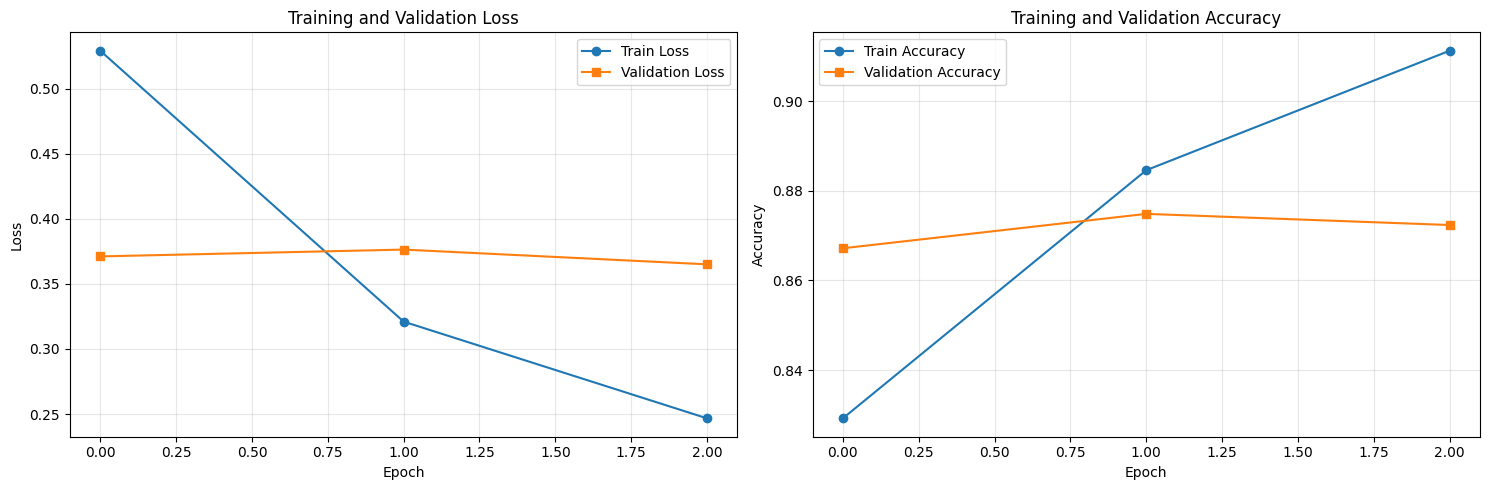


KẾT QUẢ TRAINING
Best Validation Accuracy: 0.8749
Final Train Loss: 0.2467
Final Val Loss: 0.3650
Final Train Acc: 0.9113
Final Val Acc: 0.8724

✓ Biểu đồ đã được lưu: training_history.png


In [12]:
"""
Vẽ biểu đồ Loss và Accuracy trong quá trình training
"""

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("KẾT QUẢ TRAINING")
print("="*60)
print(f"Best Validation Accuracy: {max(history['val_acc']):.4f}")
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
print(f"Final Train Acc: {history['train_acc'][-1]:.4f}")
print(f"Final Val Acc: {history['val_acc'][-1]:.4f}")
print("="*60)
print("\n✓ Biểu đồ đã được lưu: training_history.png")

In [13]:
## 7. Evaluate trên Test Set

## 8. Test Model với Câu Mẫu

In [14]:
"""
Test model với các câu tiếng Việt thật
BẢN CẢI TIẾN: Ngưỡng thông minh + Hard Mining
"""

def predict_text(text, model, tokenizer, device):
    """
    Dự đoán label cho một câu văn bản
    CẢI TIẾN V2:
    1. Tính tổng điểm tiêu cực (cumulative negative score)
    2. Áp dụng ngưỡng thông minh theo mức độ nghiêm trọng:
    - SUICIDE: >35% (CỰC KỲ NGHIÊM TRỌNG - liên quan tính mạng)
    - VIOLENCE: >40% (Đe dọa/khủng bố - liên quan tính mạng)
    - NSFW: >50% (Nội dung 18+)
    - TOXIC: >60% (Độc hại)
    - HATE: >70% (Kỳ thị - tránh bắt nhầm tranh luận)
    - TỔNG ĐIỂM TIÊU CỰC >60%: Chắc chắn nguy hiểm
    """
    model.eval()

    # Tokenize
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)[0]

    # Định nghĩa ngưỡng thông minh cho từng label
    smart_thresholds = {
        'suicide': 0.35,  # CỰC KỲ NGHIÊM TRỌNG - ngưỡng rất thấp (liên quan tính mạng)
        'violence': 0.40, # Rất nghiêm trọng - đe dọa/khủng bố (ngưỡng thấp)
        'nsfw': 0.50,     # Nội dung 18+ - ngưỡng thấp
        'toxic': 0.60,    # Độc hại - ngưỡng trung bình
        'hate': 0.70,     # Kỳ thị - ngưỡng cao (tránh false positive với tranh luận)
        'safe': 0.30      # An toàn
    }

    # Tính điểm cho từng label
    label_scores = {id2label[i]: float(probs[i]) for i in range(len(probs))}

    # BƯỚC 1: Tính tổng điểm tiêu cực (cumulative negative score)
    negative_labels = ['suicide', 'nsfw', 'violence', 'toxic', 'hate']
    cumulative_negative_score = sum(label_scores.get(label, 0.0) for label in negative_labels)

    # BƯỚC 2: Kiểm tra tổng điểm tiêu cực trước
    if cumulative_negative_score > 0.60:
        # Tổng điểm tiêu cực cao -> chắc chắn nguy hiểm
        # Chọn nhãn có điểm cao nhất trong các nhãn tiêu cực
        negative_scores = {label: label_scores[label] for label in negative_labels if label in label_scores}
        final_label = max(negative_scores.items(), key=lambda x: x[1])[0]
        final_confidence = label_scores[final_label]
    else:
        # BƯỚC 3: Áp dụng ngưỡng thông minh cho từng label
        final_label = 'safe'
        final_confidence = label_scores.get('safe', 0.0)

        # Ưu tiên kiểm tra các label nguy hiểm theo thứ tự nghiêm trọng
        for label in negative_labels:
            if label in label_scores:
                score = label_scores[label]
                threshold = smart_thresholds[label]

                if score >= threshold:
                    final_label = label
                    final_confidence = score
                    break

    return final_label, final_confidence, label_scores, cumulative_negative_score

def find_hard_cases(test_sentences, model, tokenizer, device, confidence_threshold=0.65):
    """
    HARD MINING: Tìm các trường hợp model dự đoán với confidence thấp
    Những câu này cần được gán nhãn thủ công và đưa vào tập train
    """
    print("\n" + "="*60)
    print("HARD MINING - Tìm các trường hợp khó")
    print("="*60)

    hard_cases = []

    for text in test_sentences:
        label, confidence, all_scores, cumulative_score = predict_text(text, model, tokenizer, device)

        # Tìm các trường hợp confidence thấp (model không chắc chắn)
        if confidence < confidence_threshold:
            hard_cases.append({
                'text': text,
                'predicted_label': label,
                'confidence': confidence,
                'all_scores': all_scores,
                'cumulative_negative': cumulative_score
            })

    if hard_cases:
        print(f"\nTìm thấy {len(hard_cases)} trường hợp khó (confidence < {confidence_threshold:.0%}):\n")
        for i, case in enumerate(hard_cases, 1):
            print(f"{i}. Text: {case['text']}")
            print(f"   Predicted: {case['predicted_label'].upper()} (Confidence: {case['confidence']:.2%})")
            print(f"   Tổng điểm tiêu cực: {case['cumulative_negative']:.2%}")
            print(f"   Top 3 scores:")
            top_3 = sorted(case['all_scores'].items(), key=lambda x: x[1], reverse=True)[:3]
            for label, score in top_3:
                print(f"      - {label}: {score:.2%}")
            print("-" * 60)

        print("\nKHUYẾN NGHỊ:")
        print("   1. Gán nhãn thủ công cho các câu trên")
        print("   2. Thêm vào tập train để model học lại")
        print("   3. Tập trung vào các trường hợp model nhầm lẫn giữa HATE và TOXIC")
    else:
        print(f"Không có trường hợp khó (tất cả confidence >= {confidence_threshold:.0%})")

    return hard_cases

# Test với các câu mẫu
test_sentences = [
    "Hôm nay trời đẹp quá! Mình đi chơi với bạn bè rất vui",
    "Mày là thằng ngu ngốc, đồ con chó!",
    "Bọn đồng tính phải chết hết đi",
    "Tao sẽ giết mày bây giờ",
    "Link sex của em đây anh ơi",
    "Cuộc sống vô nghĩa, tôi muốn tự tử",
    "Ảnh đẹp quá bạn ơi!",
    "Địt mẹ mày vãi lồn",
    # Thêm câu khó - tranh luận gay gắt nhưng không phải hate
    "Quan điểm của bạn sai hoàn toàn, tôi phản đối mạnh mẽ!",
    "Chính sách này thật tệ hại cho đất nước",
]

print("="*60)
print("TEST MODEL VỚI NGƯỠNG THÔNG MINH V2")
print("="*60)

for i, text in enumerate(test_sentences, 1):
    label, confidence, all_scores, cumulative_negative = predict_text(text, model, tokenizer, device)

    # Emoji theo label
    emoji_map = {
        'safe': '✅',
        'toxic': '⚠️',
        'hate': '🚫',
        'violence': '⚔️',
        'nsfw': '🔞',
        'suicide': '💀'
    }

    emoji = emoji_map.get(label, '?')

    print(f"\n{i}. Text: {text}")
    print(f"   {emoji} Prediction: {label.upper()}")
    print(f"   Confidence: {confidence:.2%}")
    print(f"   Tổng điểm tiêu cực: {cumulative_negative:.2%}")

    # Hiển thị các điểm tiêu cực
    negative_labels = ['hate', 'toxic', 'violence', 'nsfw', 'suicide']
    negative_scores = [(l, all_scores[l]) for l in negative_labels if l in all_scores and all_scores[l] > 0.05]
    if negative_scores:
        print(f"   Chi tiết: ", end="")
        print(", ".join([f"{l.capitalize()}({s:.0%})" for l, s in negative_scores]))
    print("-" * 60)

# Chạy Hard Mining
hard_cases = find_hard_cases(test_sentences, model, tokenizer, device, confidence_threshold=0.65)

print("\nTest hoàn tất!")

TEST MODEL VỚI NGƯỠNG THÔNG MINH V2

1. Text: Hôm nay trời đẹp quá! Mình đi chơi với bạn bè rất vui
   ✅ Prediction: SAFE
   Confidence: 99.60%
   Tổng điểm tiêu cực: 0.40%
------------------------------------------------------------

2. Text: Mày là thằng ngu ngốc, đồ con chó!
   🚫 Prediction: HATE
   Confidence: 93.43%
   Tổng điểm tiêu cực: 99.17%
   Chi tiết: Hate(93%)
------------------------------------------------------------

3. Text: Bọn đồng tính phải chết hết đi
   🚫 Prediction: HATE
   Confidence: 82.09%
   Tổng điểm tiêu cực: 90.67%
   Chi tiết: Hate(82%)
------------------------------------------------------------

4. Text: Tao sẽ giết mày bây giờ
   ⚔️ Prediction: VIOLENCE
   Confidence: 98.84%
   Tổng điểm tiêu cực: 99.92%
   Chi tiết: Violence(99%)
------------------------------------------------------------

5. Text: Link sex của em đây anh ơi
   🔞 Prediction: NSFW
   Confidence: 98.62%
   Tổng điểm tiêu cực: 99.92%
   Chi tiết: Nsfw(99%)
-----------------------------

## 9. Save Model để Deploy

In [15]:
"""
Save model và tokenizer để deploy
"""

import json
import os

# Tạo folder cho model
model_save_dir = './phobert_vietnamese_moderation'
os.makedirs(model_save_dir, exist_ok=True)

# Save model và tokenizer
model.save_pretrained(model_save_dir)
tokenizer.save_pretrained(model_save_dir)

# Save label mapping
with open(f'{model_save_dir}/label_mapping.json', 'w', encoding='utf-8') as f:
    json.dump({
        'label2id': label2id,
        'id2label': id2label
    }, f, ensure_ascii=False, indent=2)

# Save training history
with open(f'{model_save_dir}/training_history.json', 'w', encoding='utf-8') as f:
    json.dump(history, f, indent=2)

print("="*60)
print("ĐÃ LƯU MODEL THÀNH CÔNG!")
print("="*60)
print(f"Folder: {model_save_dir}/")
print(f"\nFiles:")
print(f"  - config.json")
print(f"  - pytorch_model.bin")
print(f"  - tokenizer files")
print(f"  - label_mapping.json")
print(f"  - training_history.json")
print("\nModel đã sẵn sàng để deploy!")
print("="*60)

# Hướng dẫn load lại model
print("\nCách load lại model:")
print("""
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('./phobert_vietnamese_moderation')
tokenizer = AutoTokenizer.from_pretrained('./phobert_vietnamese_moderation')
""")

ĐÃ LƯU MODEL THÀNH CÔNG!
Folder: ./phobert_vietnamese_moderation/

Files:
  - config.json
  - pytorch_model.bin
  - tokenizer files
  - label_mapping.json
  - training_history.json

Model đã sẵn sàng để deploy!

Cách load lại model:

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('./phobert_vietnamese_moderation')
tokenizer = AutoTokenizer.from_pretrained('./phobert_vietnamese_moderation')



In [16]:
!zip -r model_finished.zip ./phobert_vietnamese_moderation
print("Đã nén xong! Hãy tải file model_finished.zip về")

  adding: phobert_vietnamese_moderation/ (stored 0%)
  adding: phobert_vietnamese_moderation/model.safetensors (deflated 15%)
  adding: phobert_vietnamese_moderation/special_tokens_map.json (deflated 57%)
  adding: phobert_vietnamese_moderation/tokenizer_config.json (deflated 77%)
  adding: phobert_vietnamese_moderation/config.json (deflated 53%)
  adding: phobert_vietnamese_moderation/label_mapping.json (deflated 49%)
  adding: phobert_vietnamese_moderation/bpe.codes (deflated 59%)
  adding: phobert_vietnamese_moderation/added_tokens.json (stored 0%)
  adding: phobert_vietnamese_moderation/training_history.json (deflated 51%)
  adding: phobert_vietnamese_moderation/vocab.txt (deflated 55%)
Đã nén xong! Hãy tải file model_finished.zip về
